In [8]:
import torch
import torch.nn as nn
from torchvision import transforms
import os
import pandas as pd
import math
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

In [9]:
BASE_DIR = "dataset/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset"
IMG_DIR = os.path.join(BASE_DIR, "All_img")
CSV_DIR = os.path.join(BASE_DIR, "IND_and_Nep_AQI_Dataset.csv")
NEGATIVE_DATASET_IMG_DIR = "/home/mukulboro/python_projects/deblur/dataset/flickr30k_images"
random.seed(42)
negative_images = os.listdir(NEGATIVE_DATASET_IMG_DIR)
random.shuffle(negative_images)
df = pd.read_csv(CSV_DIR)
df = df[["Filename", "AQI"]]
df = df.rename(columns={"Filename": "filename", "AQI": "aqi"})
df.head()
negative_images = negative_images[:len(df)]
negative_df = pd.DataFrame({
    "filename": negative_images,
    "aqi": -1
})

combined_df = pd.concat([df, negative_df], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True) # Randomly shuffle dataframe

In [10]:
class AQIDataset(Dataset):
    def __init__(self, dataframe=combined_df, train=True, test=False, train_ratio=0.8):
        super().__init__()
        total_length = len(dataframe)
        if train == True and test == False:
            self.df = dataframe[:math.floor(train_ratio*total_length)]
        elif train == False and test == True:
            self.df = dataframe[math.floor(train_ratio*total_length):]
        else:
            raise ValueError("Invalid test and train combination")
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        current_item = self.df.iloc[index]
        if current_item["aqi"] == -1:
            img_dir = NEGATIVE_DATASET_IMG_DIR
        else:
            img_dir = IMG_DIR
        
        image = Image.open(os.path.join(img_dir, current_item["filename"]))
        image = self.transform(image)
        return {
            "aqi": current_item["aqi"],
            "image": image,
            "is_sky": 0 if current_item["aqi"] == -1 else 1
        }

class MultiDomainLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        """_summary_

        Args:
            alpha (float): weight for classification loss. Defaults to 0.5.
            beta (float): weight for regression loss. Defaults to 0.5.
        """
        super().__init__()
        self.classification_loss = nn.CrossEntropyLoss()
        self.regression_loss = nn.MSELoss()
        self.alpha = alpha
        self.beta = beta
        
    def forward(self, pred, target):
        """_summary_
        Args:
            pred (tuple): (is_sky, aqi) 
            target (tuple): (is_sky, aqi)
        """
        is_sky_pred, aqi_pred = pred
        is_sky_target, aqi_target = target

        # Classification loss
        classification_loss = self.classification_loss(is_sky_pred, is_sky_target)

        # Regression loss
        regression_loss = self.regression_loss(aqi_pred, aqi_target)

        return self.alpha * classification_loss + self.beta * regression_loss
    
    
val_dataset = AQIDataset(train=False, test=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, num_workers=2)

In [ ]:
class MultiTaskCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Shared Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # [B, 3, H, W] → [B, 16, H, W]
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.MaxPool2d(2),  # ↓↓ resolution

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # [B, 32, H/2, W/2]
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2),  # ↓↓ resolution again
            
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # [B, 32, H/2, W/2]
            nn.BatchNorm2d(32),
            nn.GELU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # [B, 64, H/4, W/4]
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((1, 1))  # → [B, 64, 1, 1]
        )

        # Classification Head
        self.classifier = nn.Sequential(
            nn.Flatten(),       # [B, 64]
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(32, 2)   
        )

        # Regression Head
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)    # output AQI as a float
        )

    def forward(self, x):
        features = self.encoder(x)

        is_sky_logits = self.classifier(features)
        aqi_pred = self.regressor(features).squeeze(1)  # [B]

        return is_sky_logits, aqi_pred


In [12]:
model_dict = torch.load("best_model.pth", map_location=torch.device('cpu'))
model_state = model_dict["model"]

model_state.keys()

odict_keys(['module.encoder.0.weight', 'module.encoder.0.bias', 'module.encoder.1.weight', 'module.encoder.1.bias', 'module.encoder.1.running_mean', 'module.encoder.1.running_var', 'module.encoder.1.num_batches_tracked', 'module.encoder.4.weight', 'module.encoder.4.bias', 'module.encoder.5.weight', 'module.encoder.5.bias', 'module.encoder.5.running_mean', 'module.encoder.5.running_var', 'module.encoder.5.num_batches_tracked', 'module.encoder.8.weight', 'module.encoder.8.bias', 'module.encoder.9.weight', 'module.encoder.9.bias', 'module.encoder.9.running_mean', 'module.encoder.9.running_var', 'module.encoder.9.num_batches_tracked', 'module.encoder.11.weight', 'module.encoder.11.bias', 'module.encoder.12.weight', 'module.encoder.12.bias', 'module.encoder.12.running_mean', 'module.encoder.12.running_var', 'module.encoder.12.num_batches_tracked', 'module.classifier.1.weight', 'module.classifier.1.bias', 'module.classifier.4.weight', 'module.classifier.4.bias', 'module.regressor.1.weight', 

In [13]:
try:
    model = MultiTaskCNN()
    # Fix state_dict - remove "module." prefix
    fixed_state_dict = {}
    for key, value in model_state.items():
        # Remove 'module.' prefix
        name = key.replace("module.", "")
        fixed_state_dict[name] = value
    model.load_state_dict(fixed_state_dict)
    model.eval()
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("If model not found, please train the model first or correct the path.")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Lists to store predictions and true values
all_is_sky_true = []
all_is_sky_pred = []
all_aqi_true = []
all_aqi_pred = []
all_images = []

# Run inference on validation set
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        images = batch["image"].to(device)
        is_sky_true = batch["is_sky"].to(device)
        aqi_true = batch["aqi"].float().to(device)
        
        # Get model predictions
        is_sky_logits, aqi_pred = model(images)
        is_sky_pred = torch.argmax(is_sky_logits, dim=1)
        
        # Store results
        all_is_sky_true.extend(is_sky_true.cpu().numpy())
        all_is_sky_pred.extend(is_sky_pred.cpu().numpy())
        all_aqi_true.extend(aqi_true.cpu().numpy())
        all_aqi_pred.extend(aqi_pred.cpu().numpy())
        
        # Store some images for visualization
        if len(all_images) < 16:
            num_to_take = min(16 - len(all_images), len(images))
            all_images.extend(images[:num_to_take].cpu())

# Convert to numpy arrays
all_is_sky_true = np.array(all_is_sky_true)
all_is_sky_pred = np.array(all_is_sky_pred)
all_aqi_true = np.array(all_aqi_true)
all_aqi_pred = np.array(all_aqi_pred)

# Calculate classification metrics
accuracy = accuracy_score(all_is_sky_true, all_is_sky_pred)
precision = precision_score(all_is_sky_true, all_is_sky_pred, average='binary')
recall = recall_score(all_is_sky_true, all_is_sky_pred, average='binary')
f1 = f1_score(all_is_sky_true, all_is_sky_pred, average='binary')

# Calculate regression metrics (only for sky images)
sky_mask = all_is_sky_true == 1
sky_aqi_true = all_aqi_true[sky_mask]
sky_aqi_pred = all_aqi_pred[sky_mask]

mae = mean_absolute_error(sky_aqi_true, sky_aqi_pred)
mse = mean_squared_error(sky_aqi_true, sky_aqi_pred)
rmse = np.sqrt(mse)
r2 = r2_score(sky_aqi_true, sky_aqi_pred)

# Print metrics
print("\nClassification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nRegression Metrics (for sky images only):")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Model loaded successfully!


Evaluating: 100%|██████████| 306/306 [00:35<00:00,  8.51it/s]


Classification Metrics:
Accuracy: 0.9841
Precision: 0.9752
Recall: 0.9930
F1 Score: 0.9840

Regression Metrics (for sky images only):
Mean Absolute Error: 26.2747
Mean Squared Error: 1216.0543
Root Mean Squared Error: 34.8720
R² Score: 0.8826


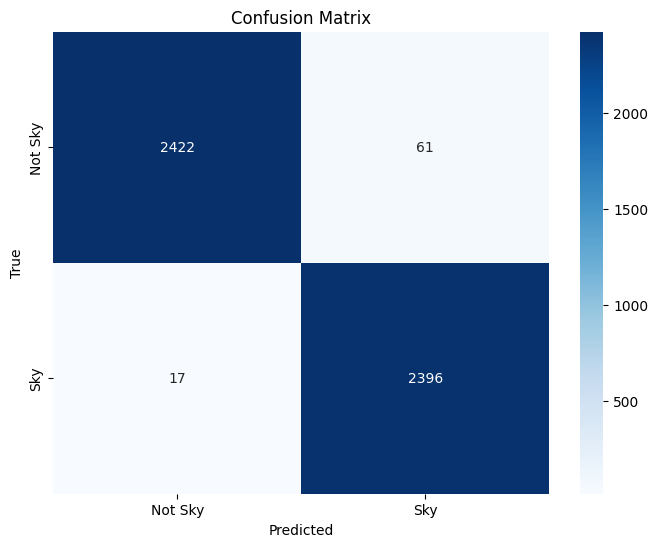

In [14]:
# Generate confusion matrix
cm = confusion_matrix(all_is_sky_true, all_is_sky_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Sky', 'Sky'], 
            yticklabels=['Not Sky', 'Sky'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

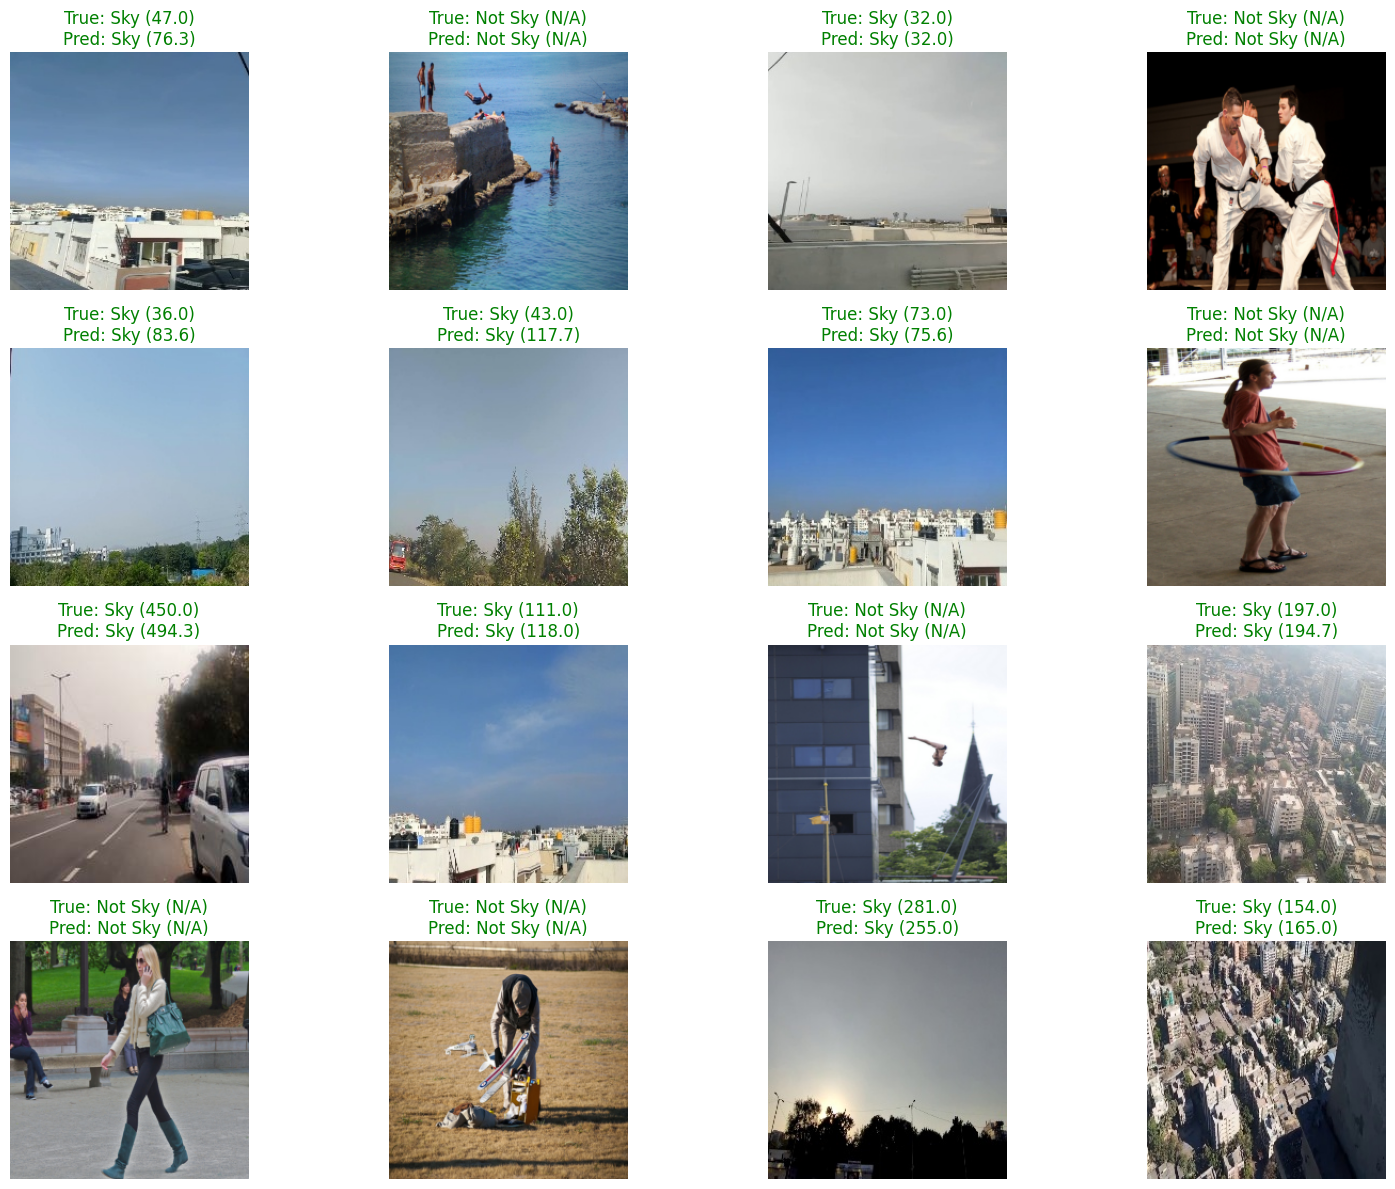

In [15]:
# Create image grid with actual and predicted values
# Create a small validation dataset for visualization
vis_batch_size = 16
vis_loader = DataLoader(val_dataset, batch_size=vis_batch_size, shuffle=True)
vis_batch = next(iter(vis_loader))

# Get predictions for visualization batch
with torch.no_grad():
    vis_images = vis_batch["image"].to(device)
    vis_is_sky_true = vis_batch["is_sky"]
    vis_aqi_true = vis_batch["aqi"]
    
    vis_is_sky_logits, vis_aqi_pred = model(vis_images)
    vis_is_sky_pred = torch.argmax(vis_is_sky_logits, dim=1)

# Create image grid with actual and predicted values
plt.figure(figsize=(16, 12))
for i in range(min(16, len(vis_images))):
    plt.subplot(4, 4, i+1)
    # Convert tensor to numpy for display
    img = vis_batch["image"][i].permute(1, 2, 0).numpy()
    # Clip values to ensure proper display
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    
    # Determine class labels
    true_class = "Sky" if vis_is_sky_true[i] == 1 else "Not Sky"
    pred_class = "Sky" if vis_is_sky_pred[i].item() == 1 else "Not Sky"
    
    # Format AQI values
    if vis_is_sky_true[i] == 1:
        true_aqi = f"{vis_aqi_true[i].item():.1f}"
    else:
        true_aqi = "N/A"
        
    if vis_is_sky_pred[i].item() == 1:
        pred_aqi = f"{vis_aqi_pred[i].item():.1f}"
    else:
        pred_aqi = "N/A"
    
    # Color-code title based on classification correctness
    title_color = "green" if vis_is_sky_true[i] == vis_is_sky_pred[i].item() else "red"
    
    plt.title(f"True: {true_class} ({true_aqi})\nPred: {pred_class} ({pred_aqi})", 
              color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.savefig('prediction_grid.png')
plt.show()

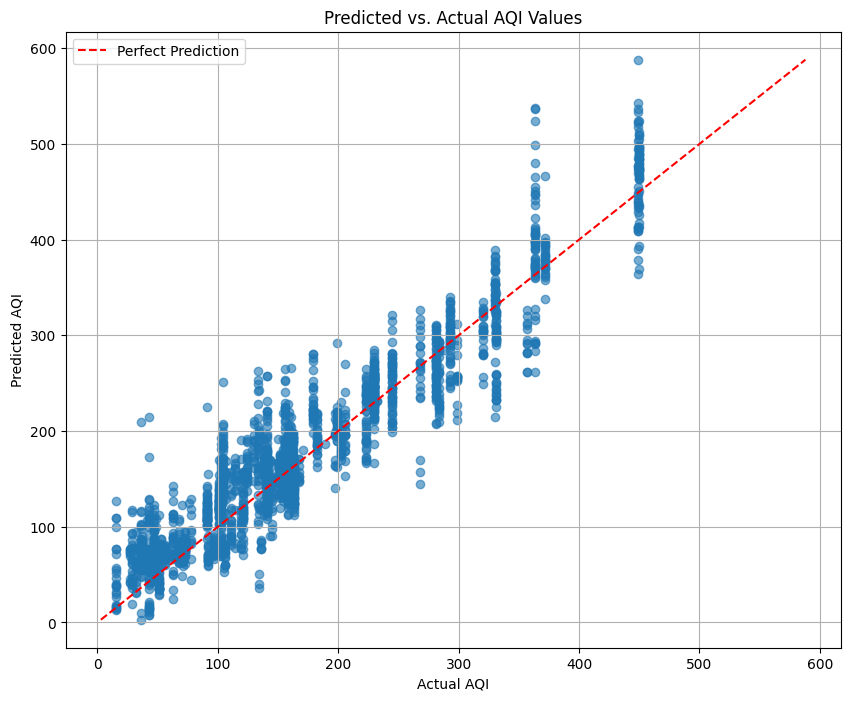

In [ ]:
plt.figure(figsize=(10, 8))

# Plot identity line (perfect predictions)
max_val = max(np.max(sky_aqi_true), np.max(sky_aqi_pred))
min_val = min(np.min(sky_aqi_true), np.min(sky_aqi_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

# Plot actual scatter points
plt.scatter(sky_aqi_true, sky_aqi_pred, alpha=0.6)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Predicted vs. Actual AQI Values')
plt.grid(True)
plt.legend()
plt.savefig('aqi_scatter_plot.png')
plt.show()

In [ ]:
def categorize_aqi(aqi):
    if aqi <= 50:
        return 0  # Good
    elif aqi <= 100:
        return 1  # Moderate
    elif aqi <= 150:
        return 2  # Unhealthy for Sensitive Groups
    elif aqi <= 200:
        return 3  # Unhealthy
    elif aqi <= 300:
        return 4  # Very Unhealthy
    else:
        return 5  # Hazardous

sky_aqi_true_cat = np.array([categorize_aqi(aqi) for aqi in sky_aqi_true])
sky_aqi_pred_cat = np.array([categorize_aqi(aqi) for aqi in sky_aqi_pred])


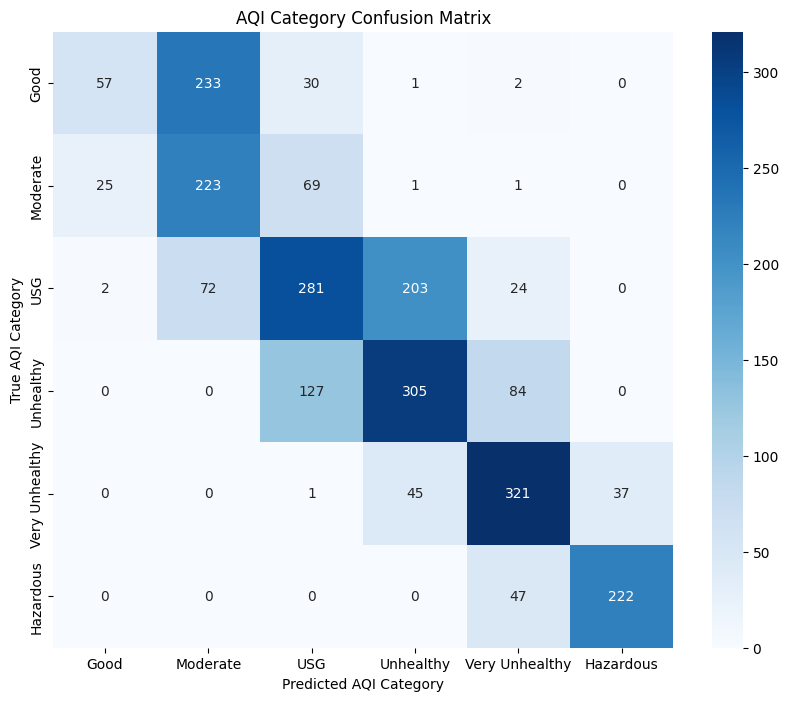

In [ ]:
aqi_cm = confusion_matrix(sky_aqi_true_cat, sky_aqi_pred_cat)

unique_categories = sorted(set(np.concatenate([sky_aqi_true_cat, sky_aqi_pred_cat])))
category_names = ['Good', 'Moderate', 'USG', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
category_labels = [category_names[i] if i < len(category_names) else f"Cat {i}" for i in unique_categories]

plt.figure(figsize=(10, 8))
sns.heatmap(aqi_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_labels,
            yticklabels=category_labels)
plt.xlabel('Predicted AQI Category')
plt.ylabel('True AQI Category')
plt.title('AQI Category Confusion Matrix')
plt.savefig('aqi_category_confusion_matrix.png')
plt.show()


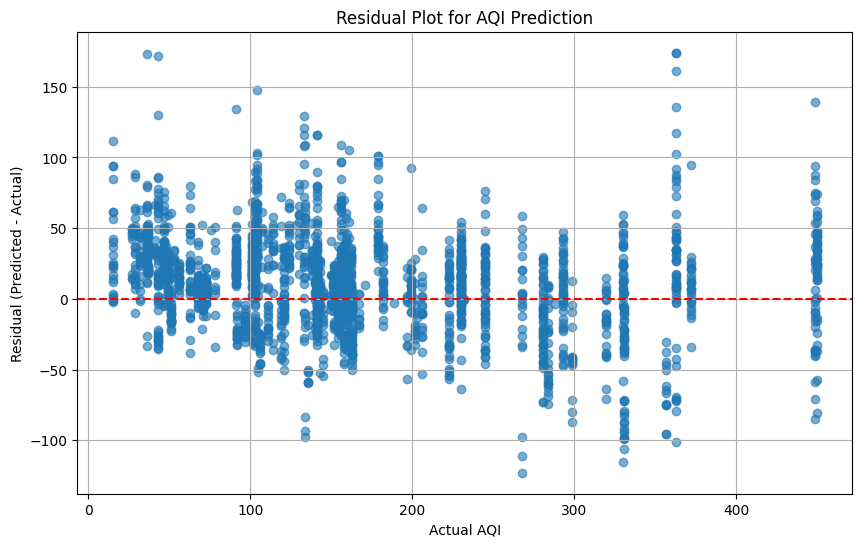

In [20]:
# Add a residual plot to show error distribution
plt.figure(figsize=(10, 6))
residuals = sky_aqi_pred - sky_aqi_true
plt.scatter(sky_aqi_true, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual Plot for AQI Prediction')
plt.grid(True)
plt.savefig('aqi_residual_plot.png')
plt.show()

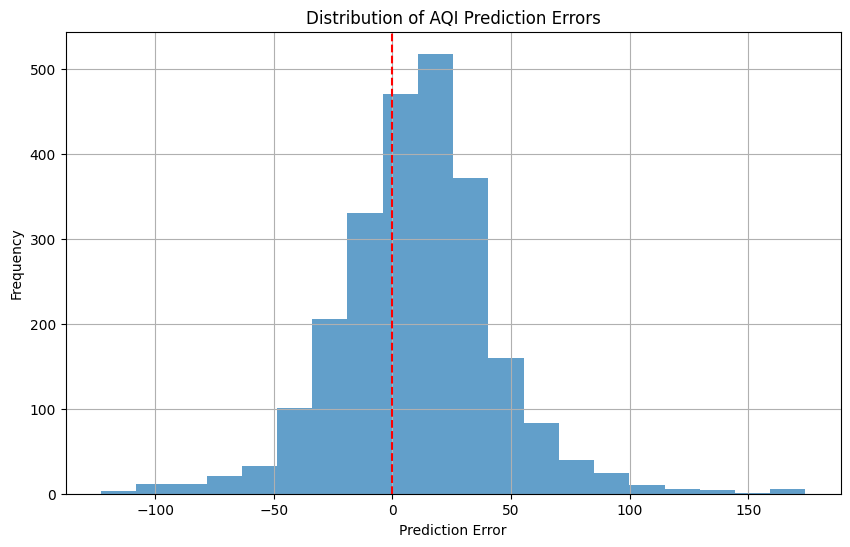

In [21]:
# Error histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of AQI Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.savefig('aqi_error_histogram.png')
plt.show()